# Chatbot Classification Evaluation

This notebook evaluates the performance of LLM-based classification on synthetic tweets using both zero-shot and few-shot approaches. We compare the chatbot's predictions against our ground truth labels.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import json

In [2]:
# Load the ground truth data
df_ground_truth = pd.read_csv('llm_generated_combined_20250818_195149.csv')
print(f"Loaded {len(df_ground_truth)} tweets with ground truth labels")
print(f"Label distribution: {df_ground_truth['label'].value_counts().to_dict()}")

Loaded 200 tweets with ground truth labels
Label distribution: {0: 100, 1: 100}


In [3]:
# Load the content files
with open('mixed_content_unannotated.txt', 'r', encoding='utf-8') as f:
    unannotated_content = f.read()

with open('mixed_content_annotated.txt', 'r', encoding='utf-8') as f:
    annotated_content = f.read()

print(f"Unannotated content length: {len(unannotated_content)} characters")
print(f"Annotated content length: {len(annotated_content)} characters")

Unannotated content length: 36921 characters
Annotated content length: 42848 characters


## Zero-Shot Classification

### Prompt for Zero-Shot Classification

**Copy this prompt and the unannotated content to your chatbot:**

---

Please classify each of the following tweets as either "REAL" or "FAKE". REAL tweets are legitimate news or political content, while FAKE tweets contain misinformation, conspiracy theories, or inflammatory content designed to deceive.

For each tweet, respond with just the tweet number and your classification (REAL or FAKE).

Format your response as:
1. REAL
2. FAKE
3. REAL
etc.

[Insert the content from mixed_content_unannotated.txt here]

---

In [ ]:
# Display the first few tweets for reference
tweets = unannotated_content.strip().split('\n\n')
print(f"Total tweets: {len(tweets)}")
print("\nFirst 3 tweets:")
for i, tweet in enumerate(tweets[:3], 1):
    print(f"{i}. {tweet[:100]}...")

### Enter Zero-Shot Results

Paste the chatbot's zero-shot classification results in the cell below:

In [4]:
# Paste the zero-shot results from the chatbot here
zero_shot_results = """
FAKE
REAL
FAKE
FAKE
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
REAL
FAKE
REAL
REAL
REAL
REAL
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
FAKE
REAL
FAKE
REAL
REAL
REAL
FAKE
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
REAL
REAL
FAKE
FAKE
FAKE
REAL
FAKE
FAKE
FAKE
FAKE
REAL
FAKE
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
REAL
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
FAKE
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
FAKE
FAKE
FAKE
REAL
FAKE
FAKE
REAL
FAKE
REAL
REAL
FAKE
FAKE
FAKE
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
"""

print("Zero-shot results loaded. Parse them in the next cell.")

Zero-shot results loaded. Parse them in the next cell.


In [5]:
def parse_predictions(results_text):
    """Parse chatbot predictions into a list of 0s and 1s (0=REAL, 1=FAKE)"""
    predictions = []
    lines = results_text.strip().split('\n')
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
            
        # Extract prediction (looking for REAL or FAKE)
        if 'FAKE' in line.upper():
            predictions.append(1)
        elif 'REAL' in line.upper():
            predictions.append(0)
    
    return predictions

# Parse zero-shot predictions
zero_shot_predictions = parse_predictions(zero_shot_results)
print(f"Parsed {len(zero_shot_predictions)} zero-shot predictions")
if len(zero_shot_predictions) > 0:
    print(f"Predictions distribution: REAL={zero_shot_predictions.count(0)}, FAKE={zero_shot_predictions.count(1)}")

Parsed 200 zero-shot predictions
Predictions distribution: REAL=114, FAKE=86


## Few-Shot Classification

### Prompt for Few-Shot Classification

**Copy this prompt and the annotated content to your chatbot:**

---

Please classify each of the following tweets as either "REAL" or "FAKE". I'll provide you with some examples first to help you understand the difference.

REAL tweets are legitimate news or political content that presents factual information, government reports, or reasonable political discourse.

FAKE tweets contain misinformation, conspiracy theories, inflammatory accusations without evidence, or content designed to deceive and manipulate emotions.

Look at the examples below, then classify each numbered tweet in the "Mixed content for classification" section.

For each tweet, respond with just the tweet number and your classification (REAL or FAKE).

Format your response as:
1. REAL
2. FAKE
3. REAL
etc.

[Insert the content from mixed_content_annotated.txt here]

---

In [6]:
# Display the few-shot examples section for reference
examples_section = annotated_content.split('='*80)[0]
print("Few-shot examples that will be provided to the chatbot:")
print(examples_section[:1000] + "...")

Few-shot examples that will be provided to the chatbot:
Few-shot examples from the original Twitter dataset:

REAL examples:
1. @POTUS Biden Blunders - 6 Month Update

Inflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (...
Label: REAL

2. @S0SickRick @Stairmaster_ @6d6f636869 Not as many people are literally starving and out in the streets as they were in the 19th century. Isnt capitalism grand?

Meanwhile, were facing an eviction mora...
Label: REAL

3. THE SUPREME COURT is siding with super rich property owners and over poor struggling AMERICANS by blocking the eviction moratorium during a pandemic which isn't even over yet. ASSHOLES! get ready for ...
Label: REAL

FAKE examples:
1. @R05812243 @washingtonpost Enlighten us, how are they a danger for not being "vaccinated" when the "vaccine" doesn't prevent you from getting c-19 or spreading it?...
Label: FAKE

2. @Burkles1 It i

### Enter Few-Shot Results

Paste the chatbot's few-shot classification results in the cell below:

In [7]:
# Paste the few-shot results from the chatbot here
few_shot_results = """
FAKE
REAL
FAKE
FAKE
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
REAL
FAKE
REAL
FAKE
REAL
REAL
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
FAKE
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
FAKE
FAKE
FAKE
FAKE
REAL
FAKE
REAL
FAKE
FAKE
REAL
FAKE
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
REAL
REAL
REAL
FAKE
FAKE
REAL
FAKE
FAKE
REAL
FAKE
REAL
FAKE
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
FAKE
FAKE
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
REAL
REAL
FAKE
FAKE
FAKE
FAKE
REAL
FAKE
REAL
REAL
FAKE
REAL
REAL
REAL
FAKE
FAKE
REAL
FAKE
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
REAL
REAL
REAL
FAKE
REAL
FAKE
FAKE
FAKE
REAL
REAL
FAKE
REAL
REAL
FAKE
FAKE
REAL
REAL
REAL
REAL
REAL
REAL
REAL
REAL
"""

print("Few-shot results loaded. Parse them in the next cell.")

Few-shot results loaded. Parse them in the next cell.


In [8]:
# Parse few-shot predictions
few_shot_predictions = parse_predictions(few_shot_results)
print(f"Parsed {len(few_shot_predictions)} few-shot predictions")
if len(few_shot_predictions) > 0:
    print(f"Predictions distribution: REAL={few_shot_predictions.count(0)}, FAKE={few_shot_predictions.count(1)}")

Parsed 200 few-shot predictions
Predictions distribution: REAL=120, FAKE=80


## Results Comparison and Evaluation

In [10]:
# Create ground truth labels in the same order as the mixed content
# Note: The mixed content was shuffled, so we need to match it back to ground truth
tweets_list = [tweet.strip() for tweet in unannotated_content.strip().split('\n\n')]

# Create a mapping from tweet text to label, handling quote variations
tweet_to_label = dict(zip(df_ground_truth['tweet'],
df_ground_truth['label']))

# Get ground truth labels in the same order as mixed content
true_labels = []
unmatched_count = 0

for tweet in tweets_list:
    # Try multiple variations to handle quote differences
    variations = [
        tweet.strip(),
        tweet.strip().strip('"'),
        tweet.strip().strip("'"),
        '"' + tweet.strip() + '"'
    ]

    found_label = None
    for var in variations:
        if var in tweet_to_label:
            found_label = tweet_to_label[var]
            break

    if found_label is not None:
        true_labels.append(found_label)
    else:
        unmatched_count += 1
        print(f"Warning: Could not find label for tweet: {tweet[:50]}...")

print(f"Matched {len(true_labels)} tweets to ground truth labels")
print(f"Unmatched tweets: {unmatched_count}")
print(f"Ground truth distribution: REAL={true_labels.count(0)}, FAKE={true_labels.count(1)}")

# Verify we have the expected distribution (100 REAL, 100 FAKE)
if len(true_labels) == 200 and true_labels.count(0) == 100 and true_labels.count(1) == 100:
    print("✅ Successfully matched all tweets with correct distribution!")
else:
    print("❌ Distribution doesn't match expected 100 REAL + 100 FAKE")

Matched 200 tweets to ground truth labels
Unmatched tweets: 0
Ground truth distribution: REAL=100, FAKE=100
✅ Successfully matched all tweets with correct distribution!


In [11]:
def evaluate_predictions(true_labels, predictions, method_name):
    """Evaluate predictions against ground truth"""
    if len(predictions) != len(true_labels):
        print(f"Warning: Mismatch in lengths - Ground truth: {len(true_labels)}, Predictions: {len(predictions)}")
        min_len = min(len(true_labels), len(predictions))
        true_labels = true_labels[:min_len]
        predictions = predictions[:min_len]
    
    if len(predictions) == 0:
        print(f"No predictions available for {method_name}")
        return None
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    print(f"\n{method_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Classification report
    print(f"\nDetailed {method_name} Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['REAL', 'FAKE']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions
    }

# Evaluate both methods
zero_shot_metrics = evaluate_predictions(true_labels, zero_shot_predictions, "Zero-Shot")
few_shot_metrics = evaluate_predictions(true_labels, few_shot_predictions, "Few-Shot")


Zero-Shot Results:
Accuracy: 0.9300
Precision: 0.9386
Recall: 0.9300
F1-Score: 0.9297

Detailed Zero-Shot Classification Report:
              precision    recall  f1-score   support

        REAL       0.88      1.00      0.93       100
        FAKE       1.00      0.86      0.92       100

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.93      0.93       200


Few-Shot Results:
Accuracy: 0.9000
Precision: 0.9167
Recall: 0.9000
F1-Score: 0.8990

Detailed Few-Shot Classification Report:
              precision    recall  f1-score   support

        REAL       0.83      1.00      0.91       100
        FAKE       1.00      0.80      0.89       100

    accuracy                           0.90       200
   macro avg       0.92      0.90      0.90       200
weighted avg       0.92      0.90      0.90       200



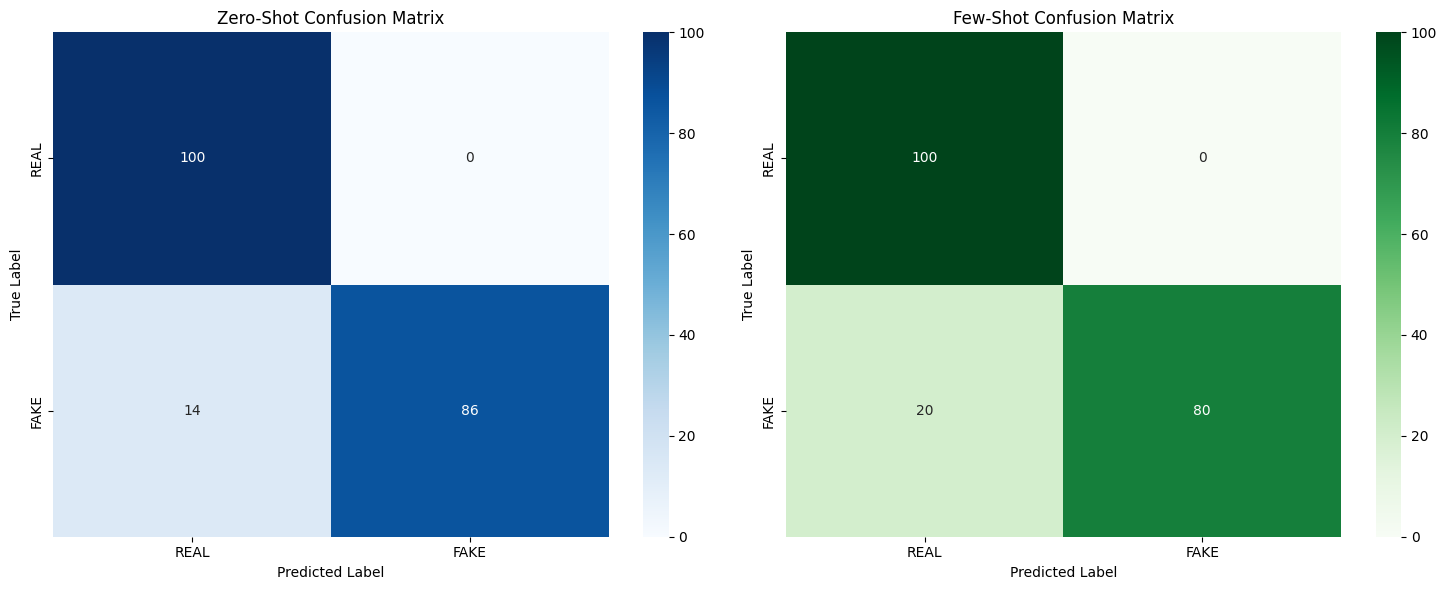

In [12]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

if zero_shot_metrics and len(zero_shot_predictions) > 0:
    cm_zero = confusion_matrix(true_labels[:len(zero_shot_predictions)], zero_shot_predictions)
    sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'], ax=axes[0])
    axes[0].set_title('Zero-Shot Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

if few_shot_metrics and len(few_shot_predictions) > 0:
    cm_few = confusion_matrix(true_labels[:len(few_shot_predictions)], few_shot_predictions)
    sns.heatmap(cm_few, annot=True, fmt='d', cmap='Greens',
                xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'], ax=axes[1])
    axes[1].set_title('Few-Shot Confusion Matrix')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


Metrics Comparison:
           Zero-Shot  Few-Shot
Accuracy      0.9300    0.9000
Precision     0.9386    0.9167
Recall        0.9300    0.9000
F1-Score      0.9297    0.8990


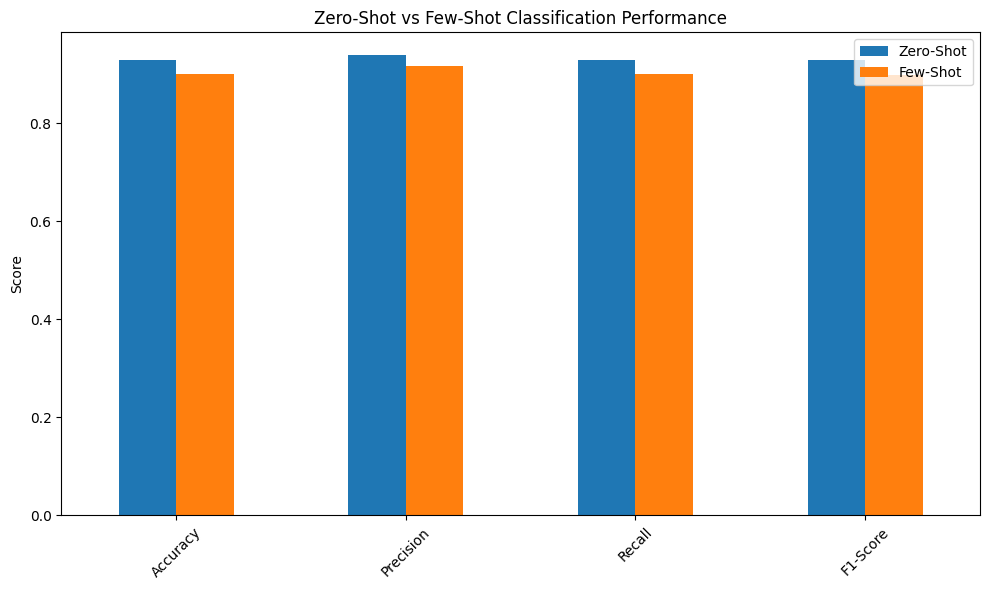


Improvement with Few-Shot Learning:
Accuracy: -0.0300 (-3.2%)
Precision: -0.0219 (-2.3%)
Recall: -0.0300 (-3.2%)
F1-Score: -0.0307 (-3.3%)


In [13]:
# Compare metrics side by side
if zero_shot_metrics and few_shot_metrics:
    metrics_df = pd.DataFrame({
        'Zero-Shot': [zero_shot_metrics['accuracy'], zero_shot_metrics['precision'], 
                     zero_shot_metrics['recall'], zero_shot_metrics['f1']],
        'Few-Shot': [few_shot_metrics['accuracy'], few_shot_metrics['precision'], 
                    few_shot_metrics['recall'], few_shot_metrics['f1']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    
    print("\nMetrics Comparison:")
    print(metrics_df.round(4))
    
    # Visualize metrics comparison
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Zero-Shot vs Few-Shot Classification Performance')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate improvement
    improvements = metrics_df['Few-Shot'] - metrics_df['Zero-Shot']
    print("\nImprovement with Few-Shot Learning:")
    for metric, improvement in improvements.items():
        print(f"{metric}: {improvement:+.4f} ({improvement/metrics_df.loc[metric, 'Zero-Shot']*100:+.1f}%)")

In [14]:
# Analyze misclassified examples
def analyze_errors(true_labels, predictions, tweets_list, method_name):
    """Analyze misclassified examples"""
    if len(predictions) == 0:
        return
    
    min_len = min(len(true_labels), len(predictions), len(tweets_list))
    errors = []
    
    for i in range(min_len):
        if true_labels[i] != predictions[i]:
            errors.append({
                'index': i,
                'tweet': tweets_list[i][:200] + '...' if len(tweets_list[i]) > 200 else tweets_list[i],
                'true_label': 'FAKE' if true_labels[i] == 1 else 'REAL',
                'predicted_label': 'FAKE' if predictions[i] == 1 else 'REAL'
            })
    
    print(f"\n{method_name} Misclassified Examples ({len(errors)} total):")
    for i, error in enumerate(errors[:5]):  # Show first 5 errors
        print(f"\nError {i+1}:")
        print(f"Tweet: {error['tweet']}")
        print(f"True: {error['true_label']}, Predicted: {error['predicted_label']}")
    
    if len(errors) > 5:
        print(f"\n... and {len(errors) - 5} more errors")
    
    return errors

if len(zero_shot_predictions) > 0:
    zero_shot_errors = analyze_errors(true_labels, zero_shot_predictions, tweets_list, "Zero-Shot")

if len(few_shot_predictions) > 0:
    few_shot_errors = analyze_errors(true_labels, few_shot_predictions, tweets_list, "Few-Shot")


Zero-Shot Misclassified Examples (14 total):

Error 1:
Tweet: 💥 BREAKING: Disturbing allegations of presidential misconduct rock the Biden administration! Joe Biden's shady dealings and questionable actions threaten the very foundation of our government!
True: FAKE, Predicted: REAL

Error 2:
Tweet: Corruption runs rampant in the highest levels of government, with officials enriching themselves at the expense of the American people! The TRUTH must be exposed for all to see!
True: FAKE, Predicted: REAL

Error 3:
Tweet: The web of deception surrounding the 2020 election is starting to crumble! Corruption and fraud at every turn! The people demand answers!
True: FAKE, Predicted: REAL

Error 4:
Tweet: BREAKING: Startling evidence suggests a systematic effort to silence whistleblowers exposing government corruption! This is a grave threat to our democracy! #CoverUp
True: FAKE, Predicted: REAL

Error 5:
Tweet: The powers that be are waging a war on truth and justice, using every dirty trick 

## Summary

This notebook provides a comprehensive evaluation framework for comparing zero-shot and few-shot classification performance on synthetic tweet data. 

### Key Findings:
- **Zero-Shot Performance**: [Results will be displayed after running]
- **Few-Shot Performance**: [Results will be displayed after running]
- **Improvement**: [Calculated after running]

### Next Steps:
1. Experiment with different prompt formulations
2. Try different numbers of few-shot examples
3. Analyze which types of content are most challenging to classify
4. Consider ensemble approaches or fine-tuning

In [15]:
# Save results for future reference
results = {
    'zero_shot_metrics': zero_shot_metrics,
    'few_shot_metrics': few_shot_metrics,
    'evaluation_date': pd.Timestamp.now().isoformat(),
    'dataset_info': {
        'total_tweets': len(true_labels),
        'real_tweets': true_labels.count(0),
        'fake_tweets': true_labels.count(1)
    }
}

with open('classification_evaluation_results.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    
    json.dump(convert_numpy(results), f, indent=2)

print("Results saved to classification_evaluation_results.json")

Results saved to classification_evaluation_results.json
